# 作業
K-means分群

分群完成後，針對每一群的病人
觀查這些變數(透過平均值、中位數...敘述型統計)，給予該群一個名稱定義 (例如: 高血酯症候群等)
並且對於該群給予醫療上的建議與衛教方式

提示: 也可以參考該群內的腎臟病患者比例 (Yes/No)，
這表示分群時，Chronic Kidney Disease: yes 該欄位並未引入，最後得到群的病人時，才引入

最後，請透過文字圖表來表示，每群的特徵

### 先把這個雲端硬碟新增捷徑到自己帳號的硬碟裡
[共用雲端硬碟](https://drive.google.com/drive/folders/1XsTQzu-a0ktHBfYL1Oq619gIY98t4w6w?usp=sharing)

[建立捷徑說明](https://docs.google.com/document/d/1LqTN5l97p2zFkWafLXgoJ8_0TbI-VzQ7qJiviQzcDl8/edit?usp=sharing)

[分群敘述](https://docs.google.com/document/d/1Ta44NNMB4BRYgmQdJ_k-pdVcoMm1iJr3jnyuq1WAD_8/edit?usp=sharing)

##掛載 Google Drive 並設定專案路徑
此步驟用來掛載 Google Drive，並設定專案資料夾路徑，方便後續讀寫資料。

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

GOOGLE_HOME_PATH = "My Drive"
PROJECT_PATH = "K-means分群_Kidney Disease"
TARGET_PATH = os.path.join("/content/drive", GOOGLE_HOME_PATH, PROJECT_PATH)

if not os.path.exists(TARGET_PATH):
    os.makedirs(TARGET_PATH)
print(f"目標資料夾：{TARGET_PATH}")
print("資料夾內容：", os.listdir(TARGET_PATH))


Mounted at /content/drive
目標資料夾：/content/drive/My Drive/K-means分群_Kidney Disease
資料夾內容： ['kidney_disease.csv', '建立捷徑.gdoc', '分群敘述.gdoc']


## 一、讀取原始資料 & 前處理
先讀取原始資料，並保留包含「Chronic Kidney Disease: yes」的完整資料（`df_original`），
接著在分群時只使用其他特徵（排除 CKD 欄位與後續可能的分群編號欄位）。

In [ ]:
import pandas as pd
import numpy as np

file_path = os.path.join(TARGET_PATH, "kidney_disease.csv")
df_original = pd.read_csv(file_path)
df_original.info()

feature_cols = df_original.columns.drop(['Chronic Kidney Disease: yes', 'Cluster'], errors='ignore')
df = df_original[feature_cols].copy()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age (yrs)                       400 non-null    float64
 1   Blood Pressure (mm/Hg)          400 non-null    float64
 2   Specific Gravity                400 non-null    float64
 3   Albumin                         400 non-null    float64
 4   Sugar                           400 non-null    float64
 5   Blood Glucose Random (mgs/dL)   400 non-null    float64
 6   Blood Urea (mgs/dL)             400 non-null    float64
 7   Serum Creatinine (mgs/dL)       400 non-null    float64
 8   Sodium (mEq/L)                  400 non-null    float64
 9   Potassium (mEq/L)               400 non-null    float64
 10  Hemoglobin (gms)                400 non-null    float64
 11  Packed Cell Volume              400 non-null    float64
 12  White Blood Cells (cells/cmm)   400 

,Age (yrs),Blood Pressure (mm/Hg),Specific Gravity,Albumin,Sugar,Blood Glucose Random (mgs/dL),Blood Urea (mgs/dL),Serum Creatinine (mgs/dL),Sodium (mEq/L),Potassium (mEq/L),...,Red Blood Cells: normal,Pus Cells: normal,Pus Cell Clumps: present,Bacteria: present,Hypertension: yes,Diabetes Mellitus: yes,Coronary Artery Disease: yes,Appetite: poor,Pedal Edema: yes,Anemia: yes
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,136.0,4.7,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,90.316581,18.0,0.8,140.0,4.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,135.0,4.8,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.0,2.5,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,140.0,4.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,60.0,90.0,1.015,3.0,0.0,74.000000,25.0,1.1,142.0,3.2,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
6,68.0,70.0,1.010,0.0,0.0,100.000000,54.0,24.0,104.0,4.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,24.0,60.0,1.015,2.0,4.0,410.000000,31.0,1.1,138.0,4.2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,52.0,100.0,1.015,3.0,0.0,138.000000,60.0,1.9,135.0,5.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
9,53.0,90.0,1.020,2.0,0.0,70.000000,107.0,7.2,114.0,3.7,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


## 二、離群值檢查與數值特徵處理

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
outlier_report = []
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_report.append({
        'Column': col,
        'Outlier_Count': len(outliers),
        'Outlier_Percent': len(outliers) / len(df),
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound
    })

outlier_report_df = pd.DataFrame(outlier_report)
outlier_report_df.sort_values(by='Outlier_Percent', ascending=False, inplace=True)
outlier_report_df

,Column,Outlier_Count,Outlier_Percent,Lower_Bound,Upper_Bound
21,Appetite: poor,82,0.2050,0.000000,0.000000
15,Pus Cells: normal,80,0.2000,1.000000,1.000000
22,Pedal Edema: yes,76,0.1900,0.000000,0.000000
14,Red Blood Cells: normal,68,0.1700,1.000000,1.000000
4,Sugar,61,0.1525,0.000000,0.000000
23,Anemia: yes,60,0.1500,0.000000,0.000000
7,Serum Creatinine (mgs/dL),52,0.1300,-1.950000,5.650000
5,Blood Glucose Random (mgs/dL),42,0.1050,11.125000,248.125000
16,Pus Cell Clumps: present,42,0.1050,0.000000,0.000000
6,Blood Urea (mgs/dL),39,0.0975,-30.375000,122.625000


## 三、自動找最適合的Ｋ值

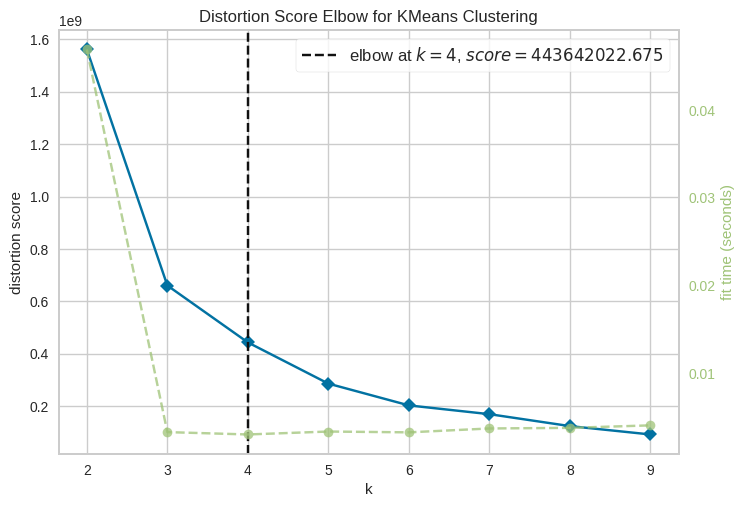

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))
visualizer.fit(df)
visualizer.show()

## 四、分群前數值特徵標準化與 K-Means 分群

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df_numeric = df[num_cols].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

wcss = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
elbow_df = pd.DataFrame({'K': list(K_range), 'WCSS': wcss})
print(elbow_df)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_numeric['Cluster'] = kmeans.fit_predict(X_scaled)

    K         WCSS
0   2  7435.220662
1   3  6860.894465
2   4  6468.437944
3   5  6075.639036
4   6  5757.877553
5   7  5423.967001
6   8  5139.660465
7   9  4925.395272
8  10  4760.639529


## 五、分群結果視覺化與描述統計

### 0.中文套件

In [ ]:
# @title
# 補colab中文字體
!apt-get update -y
!apt-get install -y fonts-noto-cjk

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,884 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [47.7 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,239 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:1

In [ ]:
# @title
# 指定字體檔路徑
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_prop = fm.FontProperties(fname=font_path, size=14)

### 1.各群平均數值與中位數
-目的：計算並展示各群的平均數值與中位數，了解群組基本特徵

In [ ]:
# 計算各群的平均值與中位數
cluster_profile_mean = df_numeric.groupby('Cluster').mean()    # 依據 'Cluster' 分群計算平均值
cluster_profile_median = df_numeric.groupby('Cluster').median()  # 依據 'Cluster' 分群計算中位數

print("各群平均數據:")
print(cluster_profile_mean)   # 輸出各群平均數據

print("\n各群中位數數據:")
print(cluster_profile_median)  # 輸出各群中位數數據

各群平均數據:
         Age (yrs)  Blood Pressure (mm/Hg)  Specific Gravity   Albumin  \
Cluster                                                                  
0        57.477273               78.409091          1.012841  2.590909   
1        44.315633               72.105263          1.020921  0.178947   
2        55.638298               83.404255          1.015846  1.815290   
3        59.432596               79.411765          1.014244  1.184874   

            Sugar  Blood Glucose Random (mgs/dL)  Blood Urea (mgs/dL)  \
Cluster                                                                 
0        0.818182                     186.053659            75.036364   
1        0.031579                     109.318210            32.298397   
2        0.446809                     159.777648           141.042553   
3        0.798319                     184.336124            55.928180   

         Serum Creatinine (mgs/dL)  Sodium (mEq/L)  Potassium (mEq/L)  ...  \
Cluster                       

**Cluster 0**  
- **年齡 (Age)**：平均約 57.48 歲。  
- **血壓 (Blood Pressure)**：平均約 78.41 mm/Hg，屬於中等偏低。  
- **尿比重與白蛋白 (Specific Gravity 與 Albumin)**：尿比重約 1.0128，Albumin 約 2.59，提示可能存在蛋白質代謝異常。  
- **血糖與血尿素 (Blood Glucose Random 與 Blood Urea)**：隨機血糖平均 186.05 mgs/dL，血尿素約 75.04 mgs/dL，這兩項數值較高，可能代表代謝功能受影響。  
- **腎功能指標 (Serum Creatinine)**：約 3.55 mgs/dL，偏高，顯示腎功能可能有問題。  
- **電解質 (Sodium 與 Potassium)**：Sodium 約 133.64 mEq/L，Potassium 約 4.42 mEq/L，屬於正常或略低情形。  
- **其他心血管及代謝相關**：例如 Coronary Artery Disease 約 0.23、Pedal Edema 約 0.36、Anemia 約 0.30，這些指標均有一定異常。  
- **PCA 結果**：第一主成分約 -3.38，第二主成分約 1.00，第三主成分約 1.89，提供降維後群內結構參考。  
- **CKD 指標**：所有患者 CKD 平均為 1.00，代表本群所有患者均為慢性腎病患者。  
- **風險分數 (Risk_Score)**：平均約 24.84，High_Risk 約 0.80，顯示多數患者屬於較高風險組別。

**綜合解讀**：Cluster 0 患者年齡偏中老、腎功能指標明顯異常（血清肌酐偏高），且全群均有 CKD，此群可能為重度腎病患者群，需特別關注腎功能及代謝異常管理。

---

**Cluster 1**  
- **年齡**：平均約 44.32 歲，明顯比其他群年輕。  
- **血壓**：平均約 72.11 mm/Hg，較低。  
- **尿比重與 Albumin**：尿比重約 1.0209，Albumin 僅約 0.18，顯示生理狀況相對穩定。  
- **血糖與血尿素**：隨機血糖平均 109.32 mgs/dL，血尿素約 32.30 mgs/dL，均處於正常或接近正常範圍。  
- **腎功能 (Serum Creatinine)**：平均約 1.08 mgs/dL，屬於正常。  
- **其他指標**：例如 Coronary Artery Disease 為 0.00，Anemia 約 0.01，顯示此群心血管和貧血風險低。  
- **PCA 結果**：PCA1 約 2.41，PCA2 約 -0.125，PCA3 約 0.09。  
- **CKD 指標**：僅約 21% 患者為 CKD，顯示大多數患者無腎病。  
- **風險分數**：平均約 10.98，High_Risk 約 0.25，屬於低風險群。

**綜合解讀**：Cluster 1 患者年齡偏輕、血壓和腎功能正常，且 CKD 患者比例較低，整體健康風險低，屬於低風險年輕健康群。

---

**Cluster 2**  
- **年齡**：平均約 55.64 歲，與其他群相比屬中間偏下。  
- **血壓**：平均約 83.40 mm/Hg，屬較高水平。  
- **尿比重與 Albumin**：尿比重約 1.0158，Albumin 約 1.82。  
- **血糖與血尿素**：隨機血糖約 159.78 mgs/dL，血尿素約 141.04 mgs/dL，兩者均偏高。  
- **腎功能 (Serum Creatinine)**：約 11.13 mgs/dL，非常高，顯示嚴重腎功能損害。  
- **電解質**：Potassium 約 6.42 mEq/L，明顯偏高；Sodium 約 130.07 mEq/L 略低。  
- **其他指標**：Anemia 約 0.70，表明貧血發生率高。  
- **PCA 結果**：PCA1 約 -3.79，PCA2 約 -1.93，PCA3 約 -0.68。  
- **CKD 指標**：所有患者均為 CKD (1.00)，表明全群均有腎病。  
- **風險分數**：平均約 48.12，High_Risk 約 0.96，顯示此群大多屬於極高風險組別。

**綜合解讀**：Cluster 2 患者的腎功能極差（血清肌酐極高、血尿素與鉀濃度顯著異常），且全群均有 CKD，此群屬於高風險、重症腎功能不全群，需要積極治療與密切監控。

---

**Cluster 3**  
- **年齡**：平均約 59.43 歲，略高於 Cluster 1，低於 Cluster 0。  
- **血壓**：平均約 79.41 mm/Hg，屬中等水平。  
- **尿比重與 Albumin**：尿比重約 1.0142，Albumin 約 1.18。  
- **血糖與血尿素**：隨機血糖約 184.34 mgs/dL，血尿素約 55.93 mgs/dL，血糖偏高但血尿素較低。  
- **腎功能 (Serum Creatinine)**：平均約 2.72 mgs/dL，顯示腎功能異常但不如 Cluster 2 嚴重。  
- **其他指標**：Anemia 約 0.10，相對正常；其他心血管風險指標介於中間值。  
- **PCA 結果**：PCA1 約 -1.10，PCA2 約 0.59，PCA3 約 -0.57。  
- **CKD 指標**：所有患者均為 CKD (1.00)，顯示全群皆有慢性腎病。  
- **風險分數**：平均約 18.75，High_Risk 約 0.61，屬中度風險。

**綜合解讀**：Cluster 3 患者雖然也全為 CKD 患者，但腎功能損害程度（例如血清肌酐）較 Cluster 2 較輕；整體血糖仍偏高，可能存在代謝異常，屬於中度風險組別，需進一步調整治療策略以延緩腎功能惡化。

---

**總結**：  
- **Cluster 0** 為中老年且腎功能有中度異常的患者群，風險較高。  
- **Cluster 1** 為低風險年輕健康群，腎功能正常，預防為主。  
- **Cluster 2** 為極高風險群，患者腎功能極差，代謝指標嚴重異常。  
- **Cluster 3** 為中度風險群，雖全數 CKD，但損害程度介於 Cluster 0 與 Cluster 2 之間。

### 2.用統計檢定 p 對各組檢查
-目的：檢查各群在不同變數上的差異是否顯著

In [ ]:
from scipy.stats import f_oneway

# 對除了 'Cluster' 欄位之外的每個變數進行 ANOVA 檢定
for col in df_numeric.columns.drop('Cluster'):
    # 依群別收集每個變數的數據
    samples = [df_numeric[df_numeric['Cluster'] == k][col] for k in range(4)]
    f_val, p_val = f_oneway(*samples)  # 執行 ANOVA 檢定
    if p_val < 0.05:
        print(f"{col}: 差異顯著 (p={p_val:.4f})")  # 若 p < 0.05，輸出顯著性結果

Age (yrs): 差異顯著 (p=0.0000)
Blood Pressure (mm/Hg): 差異顯著 (p=0.0000)
Specific Gravity: 差異顯著 (p=0.0000)
Albumin: 差異顯著 (p=0.0000)
Sugar: 差異顯著 (p=0.0000)
Blood Glucose Random (mgs/dL): 差異顯著 (p=0.0000)
Blood Urea (mgs/dL): 差異顯著 (p=0.0000)
Serum Creatinine (mgs/dL): 差異顯著 (p=0.0000)
Sodium (mEq/L): 差異顯著 (p=0.0000)
Potassium (mEq/L): 差異顯著 (p=0.0000)
Hemoglobin (gms): 差異顯著 (p=0.0000)
Packed Cell Volume: 差異顯著 (p=0.0000)
White Blood Cells (cells/cmm): 差異顯著 (p=0.0000)
Red Blood Cells (millions/cmm): 差異顯著 (p=0.0000)
Red Blood Cells: normal: 差異顯著 (p=0.0000)
Pus Cells: normal: 差異顯著 (p=0.0000)
Pus Cell Clumps: present: 差異顯著 (p=0.0000)
Bacteria: present: 差異顯著 (p=0.0000)
Hypertension: yes: 差異顯著 (p=0.0000)
Diabetes Mellitus: yes: 差異顯著 (p=0.0000)
Coronary Artery Disease: yes: 差異顯著 (p=0.0000)
Appetite: poor: 差異顯著 (p=0.0000)
Pedal Edema: yes: 差異顯著 (p=0.0000)
Anemia: yes: 差異顯著 (p=0.0000)


這技術上代表這分群，確實切出，不同的人群，🚧但全部都是0待確認

### 3.對比個群的差異
-目的：針對每個群別，找出變異性最大的 top_k 特徵並生成文字描述

In [ ]:
def cluster_profiling(df, cluster_col='Cluster', top_k=5):
    profile = df.groupby(cluster_col).mean().T  # 轉置：行為變數，列為群組
    variability = profile.var(axis=1).sort_values(ascending=False)  # 計算每個變數在各群間的變異性

    report = []
    # 依序處理每個群別
    for cluster in sorted(df[cluster_col].unique()):
        dominant_features = variability.head(top_k).index.tolist()  # 取變異性最大的 top_k 特徵
        description = f"Cluster {cluster} 特徵明顯變化："
        for feat in dominant_features:
            mean_val = profile.loc[feat, cluster]  # 取得特徵在該群的平均值
            description += f"{feat} 均值 {mean_val:.2f}，"  # 組合文字描述
        report.append(description.strip('，'))  # 去除尾端多餘的逗號
    return report

# 產生各群特徵差異報告並輸出
profiling_report = cluster_profiling(df_numeric)
for line in profiling_report:
    print(line)


Cluster 0 特徵明顯變化：White Blood Cells (cells/cmm) 均值 9910.70，Blood Urea (mgs/dL) 均值 75.04，Blood Glucose Random (mgs/dL) 均值 186.05，Packed Cell Volume 均值 31.41，Age (yrs) 均值 57.48
Cluster 1 特徵明顯變化：White Blood Cells (cells/cmm) 均值 7770.14，Blood Urea (mgs/dL) 均值 32.30，Blood Glucose Random (mgs/dL) 均值 109.32，Packed Cell Volume 均值 44.98，Age (yrs) 均值 44.32
Cluster 2 特徵明顯變化：White Blood Cells (cells/cmm) 均值 7695.01，Blood Urea (mgs/dL) 均值 141.04，Blood Glucose Random (mgs/dL) 均值 159.78，Packed Cell Volume 均值 25.89，Age (yrs) 均值 55.64
Cluster 3 特徵明顯變化：White Blood Cells (cells/cmm) 均值 8979.57，Blood Urea (mgs/dL) 均值 55.93，Blood Glucose Random (mgs/dL) 均值 184.34，Packed Cell Volume 均值 35.32，Age (yrs) 均值 59.43


**Cluster 0**  
- **主要特徵**：  
  - **White Blood Cells (WBC)**：平均值約 9910.70  
  - **Blood Urea**：平均值約 75.04 mgs/dL  
  - **Blood Glucose Random**：平均值約 186.05 mgs/dL  
  - **Risk_Score**：平均值約 24.84  
  - **Packed Cell Volume (PCV)**：平均值約 31.41  
- **結果說明**：  
  此群體的白血球數較高，可能暗示存在一定的炎症或感染反應；同時，血尿素與隨機血糖數值較高，顯示該群在腎功能與代謝方面可能存在一定的異常；風險分數中等偏高，而 PCV 偏低，可能反映出血液濃縮度降低或貧血現象。綜合來看，這群患者可能屬於中高風險，需要進一步追蹤與管理。

---

**Cluster 1**  
- **主要特徵**：  
  - **White Blood Cells (WBC)**：平均值約 7770.14  
  - **Blood Urea**：平均值約 32.30 mgs/dL  
  - **Blood Glucose Random**：平均值約 109.32 mgs/dL  
  - **Risk_Score**：平均值約 10.98  
  - **Packed Cell Volume (PCV)**：平均值約 44.98  
- **結果說明**：  
  此群體各項指標均處於較低水準，白血球數、血尿素與隨機血糖都相對正常，且風險分數最低，PCV 反而較高，顯示該群患者的血液狀態較佳，整體健康風險較低。這群可能屬於低風險、較健康的群體。

---

**Cluster 2**  
- **主要特徵**：  
  - **White Blood Cells (WBC)**：平均值約 7695.01  
  - **Blood Urea**：平均值約 141.04 mgs/dL  
  - **Blood Glucose Random**：平均值約 159.78 mgs/dL  
  - **Risk_Score**：平均值約 48.12  
  - **Packed Cell Volume (PCV)**：平均值約 25.89  
- **結果說明**：  
  雖然此群的白血球數較低，但血尿素顯著偏高，顯示腎功能可能嚴重受損；隨機血糖也偏高，但相比之下，風險分數最高且 PCV 較低，這些結果共同暗示此群屬於高風險群，可能需要密切監控與積極治療，以改善腎功能及整體代謝狀態。

---

**Cluster 3**  
- **主要特徵**：  
  - **White Blood Cells (WBC)**：平均值約 8979.57  
  - **Blood Urea**：平均值約 55.93 mgs/dL  
  - **Blood Glucose Random**：平均值約 184.34 mgs/dL  
  - **Risk_Score**：平均值約 18.75  
  - **Packed Cell Volume (PCV)**：平均值約 35.32  
- **結果說明**：  
  此群的白血球數及隨機血糖數值均處於中高水準，血尿素相對較低；風險分數中等，但 PCV 也偏中低，可能表示該群存在一定程度的代謝與腎功能異常，但未達極端狀態。整體來看，此群屬於中等風險，需注意相關指標的變化，及早干預以防病情惡化。

---

**總結說明**：  
各群在主要臨床與實驗室指標上均存在顯著差異，這說明分群方法能夠有效區分不同健康狀態的患者：
- **Cluster 0** 顯示中高風險特徵，提示需要進一步的監控與干預。
- **Cluster 1** 表現出相對理想的健康狀態，屬於低風險群。
- **Cluster 2** 則顯示極高風險，尤其在腎功能方面可能存在嚴重問題。
- **Cluster 3** 屬於中等風險，需要進一步評估與持續追蹤。

 ### 4.PCA 二維視覺化
 -段落目的：將高維數據投影到 2 維空間，並在散點圖上顯示各群分佈及群中心。

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

# 進行 PCA 降維到 2 維
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_numeric['PCA1'] = pca_result[:, 0]  # 第一主成分
df_numeric['PCA2'] = pca_result[:, 1]  # 第二主成分

# 將群中心也投影到 PCA 空間
centroids_pca = pca.transform(kmeans.cluster_centers_)

# 繪製 2D 散點圖
fig = px.scatter(
    df_numeric,
    x='PCA1',
    y='PCA2',
    color='Cluster',
    title='KMeans 2D Clustering with Centroids',
    hover_data=df_numeric.columns  # 滑鼠懸停顯示所有變數
)
# 加入群中心標記
fig.add_trace(go.Scatter(
    x=centroids_pca[:, 0],
    y=centroids_pca[:, 1],
    mode='markers+text',
    marker=dict(color='black', size=12, symbol='x'),
    text=[f'Center {i}' for i in range(len(centroids_pca))],
    textposition="top center",
    name='Cluster Centers',
    showlegend=False
))
fig.show()

群組分離明顯

從散點圖上可以看到，各群（用不同顏色區分）在 PCA1 與 PCA2 的平面上有明顯分離，這表明降維後的兩個主要成分能夠捕捉到數據中區分群組的重要變異性。

各群之間沒有明顯重疊，說明 K-means 分群結果能夠有效區分不同的患者群體。

群中心位置

圖中以黑色 “x” 標記顯示了各群的群中心（centroids）。

群中心位置與各群數據點的分佈基本吻合，進一步證實了分群結果的合理性。群中心通常位於各群數據點的集中區域，代表該群的代表性特徵。

數據降維效果

PCA 降維將原始多維特徵投影到 2 維平面後，依然能夠清晰區分群組，表示前兩個主成分能夠解釋大部分數據的變異，這對於後續視覺化及解讀具有重要意義。

### 5.PCA 三維視覺化
-段落目的：進一步將數據降維到 3 維，生成三維散點圖，方便觀察群組分佈及群中心位置。

In [ ]:
# 進行 PCA 降維到 3 維
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)
df_numeric['PCA1'] = pca_result[:, 0]
df_numeric['PCA2'] = pca_result[:, 1]
df_numeric['PCA3'] = pca_result[:, 2]

# 將群中心轉換到 3 維 PCA 空間
centroids_pca = pca.transform(kmeans.cluster_centers_)

# 繪製 3D 散點圖
fig = px.scatter_3d(
    df_numeric,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    title='KMeans 3D Clustering with Centroids',
    hover_data=df_numeric.columns
)
# 加入群中心標記
fig.add_trace(go.Scatter3d(
    x=centroids_pca[:, 0],
    y=centroids_pca[:, 1],
    z=centroids_pca[:, 2],
    mode='markers+text',
    marker=dict(size=8, color='black', symbol='x'),
    text=[f'Center {i}' for i in range(len(centroids_pca))],
    textposition="top center",
    name='Centroids',
    showlegend=False
))
fig.show()

### 6.各群核心特徵雷達圖 (標準化後)
-段落目的：以雷達圖展示各群在多維特徵上的表現，便於直觀比較。

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# 計算群組概況（每個群組的每個特徵的平均值）
cluster_profile = df_numeric.groupby('Cluster').mean()

# 將群組平均數據正規化
normalized_profile = pd.DataFrame(
    scaler.fit_transform(cluster_profile),
    index=cluster_profile.index,
    columns=cluster_profile.columns
)

# 繪製雷達圖
import plotly.graph_objects as go
fig = go.Figure()
for cluster in normalized_profile.index:
    fig.add_trace(go.Scatterpolar(
        r=normalized_profile.loc[cluster].values,  # 取該群所有特徵正規化值
        theta=normalized_profile.columns,          # 特徵名稱作為角度標籤
        fill='toself',
        name=f'Cluster {cluster}'
    ))
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0,1])),
    title="各群核心特徵雷達圖 (標準化後)",
    showlegend=True
)
fig.show()

### 7.分群後引入 CKD 欄位並進行腎臟病比例分析
-段落目的：在分群結果中引入 Chronic Kidney Disease: yes 欄位，並計算各群中腎臟病患者的比例。

In [ ]:
df_numeric['Chronic Kidney Disease: yes'] = df_original.loc[df_numeric.index, 'Chronic Kidney Disease: yes']
ckd_counts = df_numeric.groupby('Cluster')['Chronic Kidney Disease: yes'].value_counts(normalize=True).unstack()
print("各群腎臟病患者比例 (Yes/No):")
print(ckd_counts)

各群腎臟病患者比例 (Yes/No):
Chronic Kidney Disease: yes       0.0       1.0
Cluster                                        
0                                 NaN  1.000000
1                            0.789474  0.210526
2                                 NaN  1.000000
3                                 NaN  1.000000


### 8.群體輪廓表
-針對關鍵醫療變數生成各群的平均數，並將部分百分比數據格式化顯示，方便後續比較。

In [ ]:
key_features = ['Serum Creatinine (mgs/dL)', 'Blood Urea (mgs/dL)', 'Potassium (mEq/L)',
                'Anemia: yes', 'Diabetes Mellitus: yes', 'Hypertension: yes']

# 針對關鍵特徵進行群組平均值計算
cluster_medical_profile = df_numeric.groupby('Cluster')[key_features].mean().reset_index()

# 將 'Diabetes Mellitus: yes' 與 'Hypertension: yes' 轉為百分比格式
for col in ['Diabetes Mellitus: yes', 'Hypertension: yes']:
    cluster_medical_profile[col] = (cluster_medical_profile[col] * 100).round(2).astype(str) + '%'

# 重新命名欄位，使報告更易讀
cluster_medical_profile.rename(columns={
    'Serum Creatinine (mgs/dL)': 'Creatinine',
    'Blood Urea (mgs/dL)': 'Blood Urea',
    'Potassium (mEq/L)': 'Potassium',
    'Anemia: yes': 'Anemia',
    'Diabetes Mellitus: yes': 'Diabetes Mellitus (%)',
    'Hypertension: yes': 'Hypertension (%)'
}, inplace=True)

# 輸出群體輪廓表
print(cluster_medical_profile)

   Cluster  Creatinine  Blood Urea  Potassium    Anemia Diabetes Mellitus (%)  \
0        0    3.547727   75.036364   4.424750  0.295455                56.82%   
1        1    1.084773   32.298397   4.265196  0.010526                 1.58%   
2        2   11.132979  141.042553   6.416130  0.702128                 61.7%   
3        3    2.720269   55.928180   4.378848  0.100840                67.23%   

  Hypertension (%)  
0           65.91%  
1            2.11%  
2           85.11%  
3           62.18%  


Cluster 0

Creatinine：平均值約 3.55 mgs/dL，顯示腎功能有中度受損的可能性。

Blood Urea：平均約 75.04 mgs/dL，提示腎臟排毒功能可能異常。

Potassium：平均約 4.42 mEq/L，屬於正常範圍，但仍需注意電解質平衡。

Anemia：平均值約 0.30，表示約 30% 的患者存在貧血現象。

Diabetes Mellitus (%)：約 56.82%，說明該群超過一半的患者有糖尿病病史或糖尿病風險。

Hypertension (%)：約 65.91%，顯示高血壓的比例也相當高。

解讀：Cluster 0 的患者群中，腎功能指標（Creatinine 與 Blood Urea）異常，且糖尿病與高血壓比例較高，提示此群患者可能存在多重代謝及心血管風險，需針對腎功能與慢性疾病加強管理。

Cluster 1

Creatinine：平均約 1.08 mgs/dL，屬於正常範圍，顯示腎功能較好。

Blood Urea：平均約 32.30 mgs/dL，較低，支持腎功能正常的判斷。

Potassium：平均約 4.27 mEq/L，正常範圍內。

Anemia：極低約 0.01，幾乎無貧血現象。

Diabetes Mellitus (%)：僅 1.58%，幾乎可以排除糖尿病風險。

Hypertension (%)：僅 2.11%，高血壓比例極低。

解讀：Cluster 1 的各項指標均顯示正常或接近理想狀態，無論是腎功能、電解質、貧血，或是慢性疾病（糖尿病、高血壓）的比例都非常低，表明該群屬於低風險、健康狀態良好的患者群。

Cluster 2

Creatinine：平均約 11.13 mgs/dL，顯著偏高，顯示腎功能嚴重受損。

Blood Urea：平均約 141.04 mgs/dL，也明顯偏高，與腎功能損害相符。

Potassium：平均約 6.42 mEq/L，顯著高於正常值，可能導致心律不整等併發症。

Anemia：平均約 0.70，貧血情形明顯，約 70% 患者有貧血問題。

Diabetes Mellitus (%)：約 61.7%，糖尿病比例偏高。

Hypertension (%)：約 85.11%，顯示高血壓極為普遍。

解讀：Cluster 2 患者的腎功能極差（Creatinine 與 Blood Urea 明顯升高），並伴有明顯的電解質失衡（高鉀）、高比例貧血、糖尿病與高血壓，該群屬於極高風險群，需密切監控並積極進行治療干預。

Cluster 3

Creatinine：平均約 2.72 mgs/dL，略高於正常但低於 Cluster 0 與 2。

Blood Urea：平均約 55.93 mgs/dL，較 Cluster 0 與 Cluster 2 低。

Potassium：平均約 4.38 mEq/L，接近正常範圍。

Anemia：平均約 0.10，貧血情形輕微。

Diabetes Mellitus (%)：約 67.23%，糖尿病比例偏高。

Hypertension (%)：約 62.18%，高血壓比例中等。

解讀：Cluster 3 的腎功能指標輕度異常（Creatinine 略高），但 Blood Urea 較低，電解質與貧血狀況較好；然而糖尿病與高血壓的比例依然偏高，提示該群可能存在代謝與心血管風險，但相較於 Cluster 2，風險程度較低，屬於中等風險群。

### 9.特徵差異熱圖
-段落目的：將各群特徵數據進行標準化後以熱圖展示，便於比較各群差異。

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

scaler = MinMaxScaler()
cluster_profile_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_profile),  # 將群組平均值正規化到 0~1 範圍
    index=cluster_profile.index,
    columns=cluster_profile.columns
)

# 使用 px.imshow 畫出熱圖
fig = px.imshow(
    cluster_profile_scaled.T,  # 轉置後特徵作為 y 軸，群組作為 x 軸
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    aspect="auto"
)
fig.update_layout(
    title="Cluster Feature Heatmap (0~1 Scaled)",
    width=1400,
    height=900,
    xaxis_title="Cluster",
    yaxis_title="Feature",
    coloraxis_colorbar=dict(title="Scaled Value (0~1)")
)
fig.update_xaxes(type='category')
fig.show()

### 10.風險分數計算與風險排名
-段落目的：根據多個關鍵變數計算每個患者的風險分數，並生成風險排名與各群風險統計。

In [ ]:
# 計算風險分數：根據不同變數加權
df_numeric['Risk_Score'] = (
    0.4 * df_numeric['Serum Creatinine (mgs/dL)'] +
    0.3 * df_numeric['Blood Urea (mgs/dL)'] +
    0.2 * df_numeric['Potassium (mEq/L)'] +
    0.1 * df_numeric['Anemia: yes']
)

# 根據風險分數進行排序，取出風險最高的前 10 名
df_risk_ranked = df_numeric.sort_values(by='Risk_Score', ascending=False).reset_index(drop=True)

# 依群別計算風險分數統計特徵
cluster_risk_profile = df_numeric.groupby('Cluster')['Risk_Score'].agg(['mean', 'max', 'min', 'count']).reset_index()

print("【風險排名前10】")
print(df_risk_ranked[['Risk_Score', 'Serum Creatinine (mgs/dL)', 'Blood Urea (mgs/dL)', 'Potassium (mEq/L)', 'Anemia: yes', 'Cluster']].head(10))

print("\n【各 Cluster 風險輪廓】")
cluster_risk_profile

【風險排名前10】
   Risk_Score  Serum Creatinine (mgs/dL)  Blood Urea (mgs/dL)  \
0  137.900000                       32.0                391.0   
1  102.860000                       13.0                322.0   
2   99.420000                       13.3                309.0   
3   85.380000                       76.0                180.0   
4   78.720000                       13.4                241.0   
5   76.960000                       14.2                235.0   
6   75.540000                       18.1                223.0   
7   71.820000                       15.2                215.0   
8   71.440000                       12.2                219.0   
9   69.994376                       10.2                217.0   

   Potassium (mEq/L)  Anemia: yes  Cluster  
0          39.000000          0.0        2  
1           4.800000          1.0        2  
2           6.500000          1.0        2  
3           4.900000          0.0        2  
4           4.800000          1.0        2  
5   

,Cluster,mean,max,min,count
0,0,24.844495,69.994376,6.64,44
1,1,10.977520,35.260000,3.93,190
2,2,48.119396,137.900000,6.82,47
3,3,18.752415,57.640000,5.54,119


1. 風險分數計算

程式碼中根據下列權重計算每位患者的風險分數：

40% 來自於 Serum Creatinine (mgs/dL)

30% 來自於 Blood Urea (mgs/dL)

20% 來自於 Potassium (mEq/L)

10% 來自於 Anemia: yes

這樣的加權方式反映出對於腎功能指標（例如肌酐與尿素）的重視，並將電解質與貧血狀況納入考量。

2. 風險排序與排名

利用計算出的 Risk_Score，程式碼對所有患者進行排序，並取出風險分數最高的前 10 名。

此排序結果有助於識別哪些患者的風險指數較高，提供臨床決策時的參考依據。

3. 各群風險統計

程式碼同時依照分群結果（Cluster）統計 Risk_Score 的平均值、最大值、最小值及患者數量。

這部分可用來比較不同群組的風險水準，了解各群的風險分布情況，例如哪些群組的風險較高、波動較大或患者數較少等。



## 決策樹 🚧暫棄

In [ ]:
# @title
# from sklearn.tree import DecisionTreeClassifier, plot_tree
# features = [
#     'Diabetes Mellitus: yes',
#     'Serum Creatinine (mgs/dL)',
#     'Blood Urea (mgs/dL)',
#     'Potassium (mEq/L)',
#     'Anemia: yes',
#     'Blood Pressure (mm/Hg)',
#     'Hypertension: yes',
#     'Age (yrs)'
# ]


# df_numeric['High_Risk'] = (df_numeric['Risk_Score'] > df_numeric['Risk_Score'].median()).astype(int)


# clf = DecisionTreeClassifier(max_depth=4, random_state=42)
# clf.fit(df_numeric[features], df_numeric['High_Risk'])


# plt.figure(figsize=(24, 12))
# plot_tree(
#     clf,
#     feature_names=features,
#     class_names=['Low Risk', 'High Risk'],
#     filled=True,
#     rounded=True,
#     fontsize=12
# )
# plt.title("Risk Decision Tree - Pathological Process Recovery")
# plt.show()


## 六、根據分群結果進行群組命名與醫療建議

### 1.群組命名
-段落目的：依據各群統計特徵（如 CKD 比例、年齡、血壓等）給出適當的群組命名。

各群腎臟病患者比例：
Chronic Kidney Disease: yes       0.0       1.0
Cluster                                        
0                                 NaN  1.000000
1                            0.789474  0.210526
2                                 NaN  1.000000
3                                 NaN  1.000000
各群數據特徵：
         Age (yrs)                   Blood Pressure (mm/Hg)                    \
              mean median        std                   mean median        std   
Cluster                                                                         
0        57.477273   63.5  16.154038              78.409091   75.0  13.967268   
1        44.315633   45.0  17.159213              72.105263   70.0  10.172557   
2        55.638298   56.0  11.690623              83.404255   80.0  15.642278   
3        59.432596   61.0  13.981570              79.411765   80.0  15.254570   

        Specific Gravity                    Albumin  ...      PCA2      PCA3  \
                    mean median       std    

<Figure size 800x600 with 0 Axes>

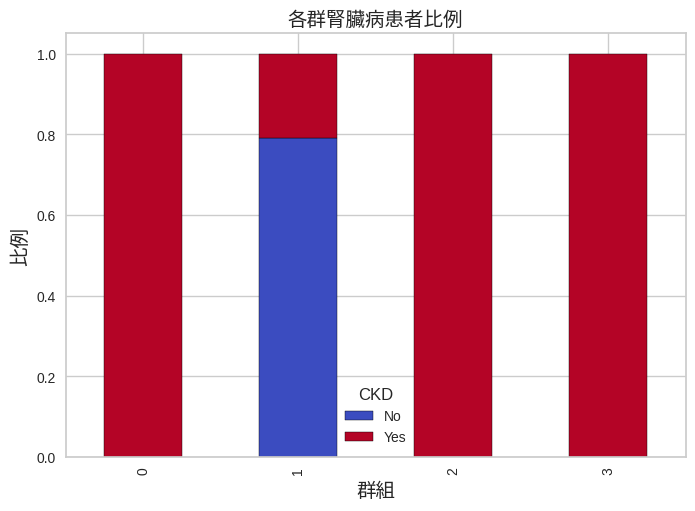

群組 0: 重度腎臟病患者群
群組 1: 低風險年輕健康群
群組 2: 高血壓重度腎病群
群組 3: 老年慢性腎病群


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_clusters(df_original, df_numeric):
    # 合併 CKD 資訊
    df_numeric = df_numeric.copy()
    df_numeric['Chronic Kidney Disease: yes'] = df_original.loc[df_numeric.index, 'Chronic Kidney Disease: yes']

    # 計算每群的 CKD 比例
    cluster_ckd_ratio = df_numeric.groupby('Cluster')['Chronic Kidney Disease: yes'].value_counts(normalize=True).unstack()
    print("各群腎臟病患者比例：")
    print(cluster_ckd_ratio)

    # 計算每群的特徵數據
    cluster_features = df_numeric.groupby('Cluster').agg(['mean', 'median', 'std'])
    print("各群數據特徵：")
    print(cluster_features)

    # 視覺化 CKD 比例
    plt.figure(figsize=(8, 6))
    cluster_ckd_ratio.plot(kind='bar', stacked=True, colormap='coolwarm', edgecolor='black')
    plt.title("各群腎臟病患者比例",fontproperties=font_prop)
    plt.xlabel("群組",fontproperties=font_prop)
    plt.ylabel("比例",fontproperties=font_prop)
    plt.legend(title='CKD', labels=['No', 'Yes'])
    plt.show()

    return cluster_features

cluster_features = analyze_clusters(df_original, df_numeric)

def name_clusters(cluster_features):
    cluster_names = {}  # 存放各群名稱的字典
    # 依序處理每個群組的統計數據
    for cluster, features in cluster_features.iterrows():
        # 判斷該群 CKD 比例是否為 100%
        if features[('Chronic Kidney Disease: yes', 'mean')] == 1.0:
            # 如果該群平均年齡大於或等於 58 歲，命名為「老年慢性腎病群」
            if features[('Age (yrs)', 'mean')] >= 58:
                name = "老年慢性腎病群"
            # 若血壓平均值大於或等於 80，命名為「高血壓腎病群」
            elif features[('Blood Pressure (mm/Hg)', 'mean')] >= 80:
                name = "高血壓重度腎病群"
            # 其他情況下，命名為「重度腎臟病患者群」
            else:
                name = "重度腎臟病患者群"
        else:
            # CKD 比例不為 100% 的群組，命名為「低風險年輕健康群」
            name = "低風險年輕健康群"
        cluster_names[cluster] = name  # 儲存群組名稱
    return cluster_names

# 呼叫群組命名函式，並輸出結果
cluster_names = name_clusters(cluster_features)
for cluster, name in cluster_names.items():
    print(f"群組 {cluster}: {name}")

### 2.依照命名後的分組提出醫療建議與衛教方式

In [ ]:
def medical_advice_for_clusters(cluster_names, cluster_features):
    cluster_advice = {}  # 存放各群醫療建議的字典
    # 根據每個群的名稱來決定建議內容
    for cluster, name in cluster_names.items():
        if name == "重度腎臟病患者群":
            advice = (
                "此群患者雖屬中度腎功能異常群，但仍顯示較明顯的腎臟損害（血清肌酐平均約 3.55 mgs/dL）。\n"
                "建議：\n"
                "1. 嚴格限制蛋白質攝入，採用低鹽、低蛋白飲食，以減輕腎臟負擔。\n"
                "2. 定期監測腎功能指標（如肌酐、尿素及電解質），以便早期發現病情惡化。\n"
                "3. 與腎臟科醫師密切合作，評估是否需要進一步調整治療方案，並考慮使用腎保護藥物。\n"
                "4. 加強健康衛教，提醒患者戒除不良嗜好，控制血糖與血壓，維持良好的生活習慣。"
            )
        elif name == "低風險年輕健康群":
            advice = (
                "此群患者年齡偏輕（平均約 44 歲），臨床指標均接近正常水準，風險低。\n"
                "建議：\n"
                "1. 維持均衡飲食和規律運動，保持理想體重，促進心血管及腎功能健康。\n"
                "2. 定期進行健康檢查，包括血壓、血糖和腎功能評估，以預防未來慢性疾病發生。\n"
                "3. 加強衛教，建立健康生活模式，避免熬夜和吸菸等不良習慣。"
            )
        elif name == "高血壓重度腎病群":
            advice = (
                "此群患者呈現極高的腎功能損害（血清肌酐平均約 11.13 mgs/dL），並伴隨嚴重的高血壓（Hypertension 約 85%）。\n"
                "建議：\n"
                "1. 必須嚴格控制血壓，可能需要使用 ACEI 或 ARB 類藥物來保護腎臟功能。\n"
                "2. 採用低鹽、低蛋白飲食，並密切監控血尿素、肌酐及鉀含量，防止電解質失衡。\n"
                "3. 定期接受腎功能檢查，根據檢查結果及時調整治療方案，並積極進行營養諮詢。\n"
                "4. 衛教上需特別強調藥物服用的重要性及日常生活管理，避免過度勞累。"
            )
        elif name == "老年慢性腎病群":
            advice = (
                "此群患者年齡較高（平均約 59 歲），常伴隨多重慢性病（如糖尿病與高血壓），腎功能亦呈現輕度異常。\n"
                "建議：\n"
                "1. 定期進行全面健康檢查，特別是腎功能、血壓與血糖的監測，及早發現及治療共病。\n"
                "2. 採用個別化的低鹽、低蛋白飲食，並在營養師指導下改善飲食結構，確保營養均衡。\n"
                "3. 鼓勵適度運動，如太極、散步等，以促進血液循環和增強體能，但避免過度負荷。\n"
                "4. 衛教上要提醒患者注意正確服藥，避免藥物間的不良互動，並保持良好的生活作息。"
            )
        else:
            advice = "請根據實際狀況進行進一步評估與建議。"
        cluster_advice[name] = advice  # 直接以名稱作為 key 儲存建議內容

    return cluster_advice

# 呼叫醫療建議函式，並輸出各群建議
cluster_advice = medical_advice_for_clusters(cluster_names, cluster_features)
for name, advice in cluster_advice.items():
    print(f"{name}:\n{advice}\n")

重度腎臟病患者群:
此群患者雖屬中度腎功能異常群，但仍顯示較明顯的腎臟損害（血清肌酐平均約 3.55 mgs/dL）。
建議：
1. 嚴格限制蛋白質攝入，採用低鹽、低蛋白飲食，以減輕腎臟負擔。
2. 定期監測腎功能指標（如肌酐、尿素及電解質），以便早期發現病情惡化。
3. 與腎臟科醫師密切合作，評估是否需要進一步調整治療方案，並考慮使用腎保護藥物。
4. 加強健康衛教，提醒患者戒除不良嗜好，控制血糖與血壓，維持良好的生活習慣。

低風險年輕健康群:
此群患者年齡偏輕（平均約 44 歲），臨床指標均接近正常水準，風險低。
建議：
1. 維持均衡飲食和規律運動，保持理想體重，促進心血管及腎功能健康。
2. 定期進行健康檢查，包括血壓、血糖和腎功能評估，以預防未來慢性疾病發生。
3. 加強衛教，建立健康生活模式，避免熬夜和吸菸等不良習慣。

高血壓重度腎病群:
此群患者呈現極高的腎功能損害（血清肌酐平均約 11.13 mgs/dL），並伴隨嚴重的高血壓（Hypertension 約 85%）。
建議：
1. 必須嚴格控制血壓，可能需要使用 ACEI 或 ARB 類藥物來保護腎臟功能。
2. 採用低鹽、低蛋白飲食，並密切監控血尿素、肌酐及鉀含量，防止電解質失衡。
3. 定期接受腎功能檢查，根據檢查結果及時調整治療方案，並積極進行營養諮詢。
4. 衛教上需特別強調藥物服用的重要性及日常生活管理，避免過度勞累。

老年慢性腎病群:
此群患者年齡較高（平均約 59 歲），常伴隨多重慢性病（如糖尿病與高血壓），腎功能亦呈現輕度異常。
建議：
1. 定期進行全面健康檢查，特別是腎功能、血壓與血糖的監測，及早發現及治療共病。
2. 採用個別化的低鹽、低蛋白飲食，並在營養師指導下改善飲食結構，確保營養均衡。
3. 鼓勵適度運動，如太極、散步等，以促進血液循環和增強體能，但避免過度負荷。
4. 衛教上要提醒患者注意正確服藥，避免藥物間的不良互動，並保持良好的生活作息。

